# Overfitting and Regularization

## Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [5]:
set_config(display='diagram')

## Settings

In [6]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [58]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

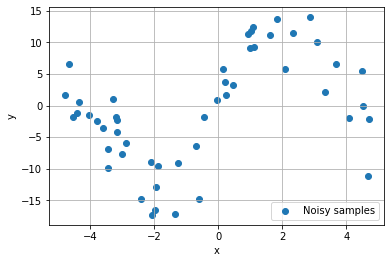

In [11]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

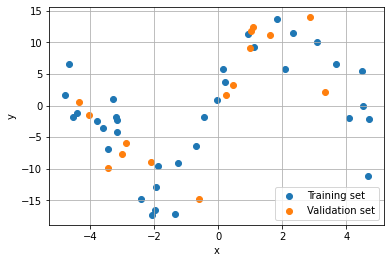

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [13]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [14]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

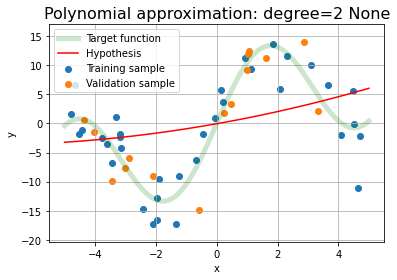

In [15]:
def plot_fit(model, add_title=None):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree} '+str(add_title), fontsize=16)
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

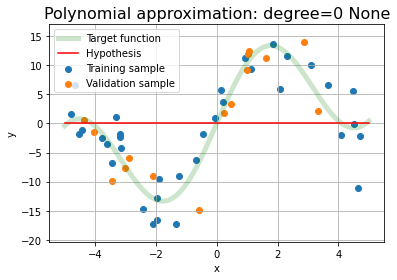

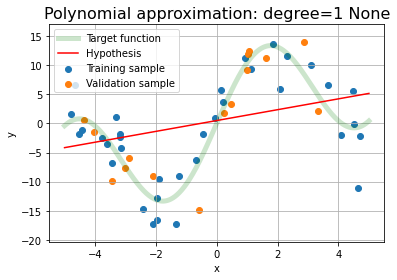

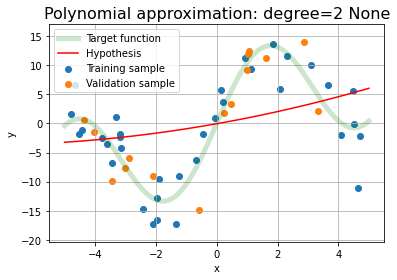

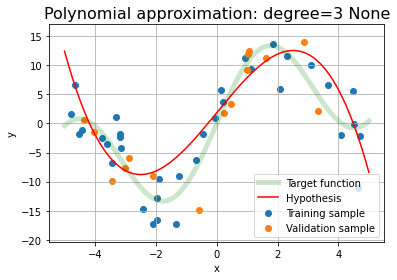

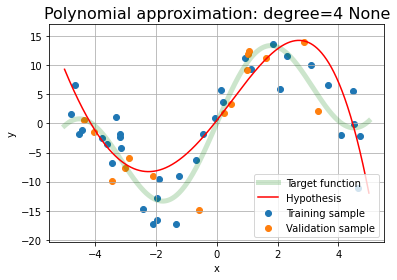

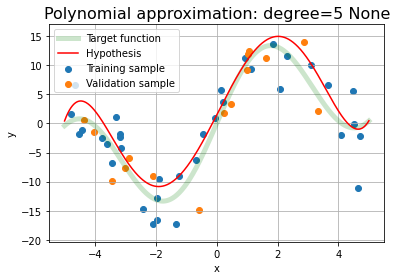

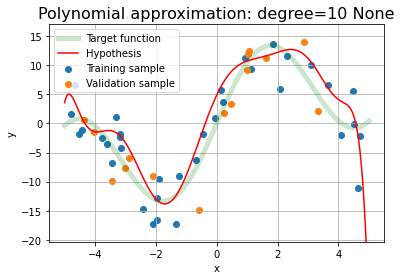

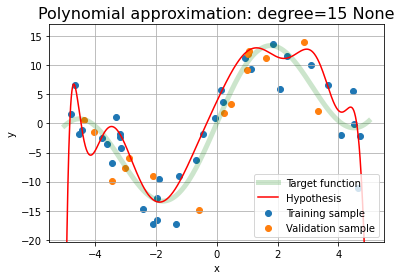

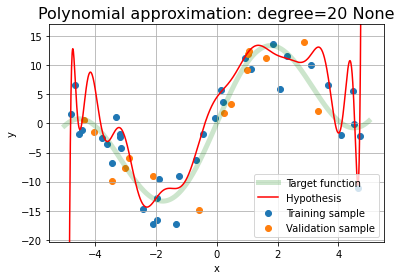

In [16]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

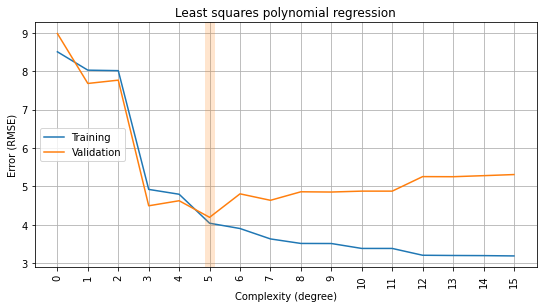

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [18]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

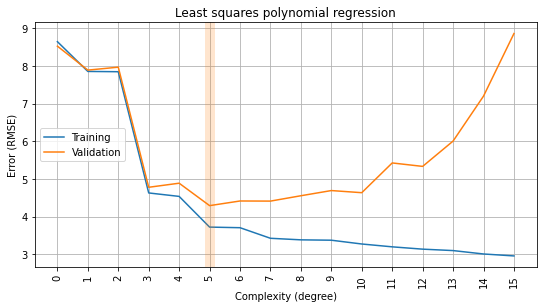

In [19]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [20]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

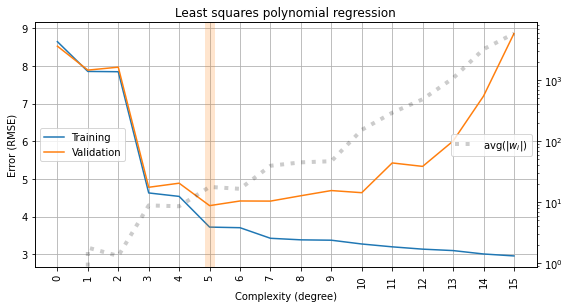

In [21]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

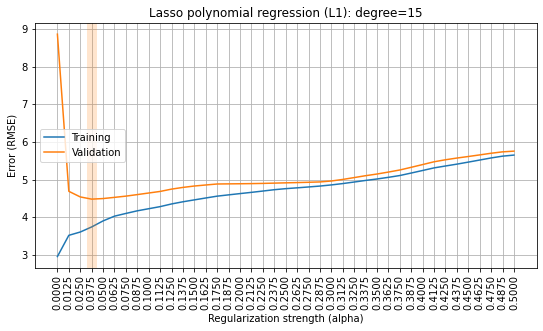

In [22]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

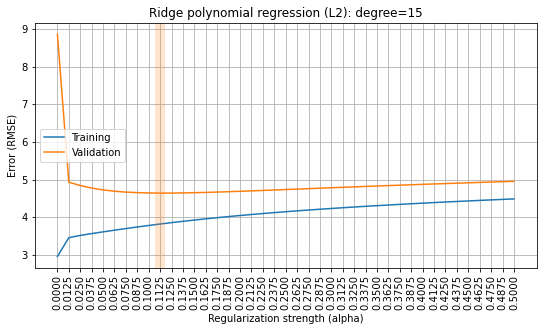

In [23]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [20]:
import re
def task1(ALPHAS, w, 
          title=None, palette=None):
    '''Consider weights are functions of Alpha (regularization parameter).
    This function plots weights graphs and returns weights pd.DataFram'''
    
    abs_avg_w=[ np.mean(np.abs(row)) for row in w]
    df=pd.DataFrame(w)
    df=df.rename(columns= lambda col: 'w'+str(col))
    df.insert(0, 'Alpha', ALPHAS)

    #unpivoting df
    df=df.melt('Alpha', var_name='w_i', value_name='w_val')
    #plotting weights from df
    g=sns.relplot(x='Alpha', y='w_val', data=df, hue='w_i',
              kind='line', height=9, aspect=2, palette=palette, linewidth=2)
    g.set(yscale='symlog')
    plt.xlabel("Alpha", fontsize=16)
    plt.ylabel("Weight", fontsize=16)
    plt.grid(True)
    plt.xticks(ALPHAS, rotation='vertical')
    


    #plotting abs average weight
    plt.twinx()#to share xaxis betwen an old and a new plot
    plt.yscale('log')
    plt.plot(ALPHAS, abs_avg_w, alpha=0.5, lw=4, ls='dotted', color='black', label='abs_average_w')
    plt.ylabel("Abs average weight", fontsize=16, loc='top')
    plt.legend(loc='lower right')
    
    plt.title(title, fontsize=16)
    
    
    #pivoting df back
    #df.drop(columns=['w_i'])
    df=df.pivot(index='Alpha', columns='w_i', values='w_val')
    df=df.rename(lambda col: float(re.findall(r'([0-9]+)', col)[0]), axis=1)
    df=df.reindex(sorted(df.columns), axis=1)
    return df

#### L1

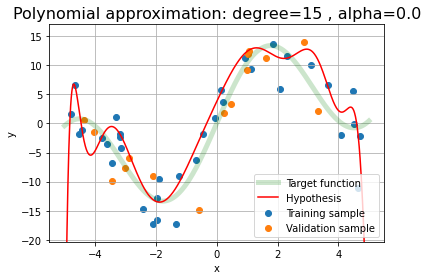

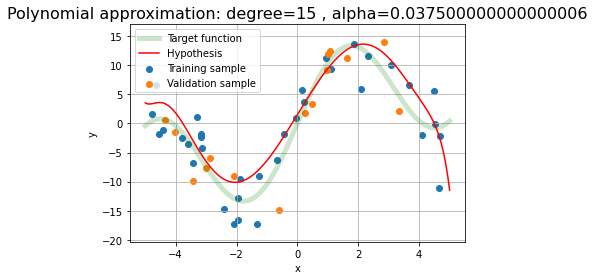

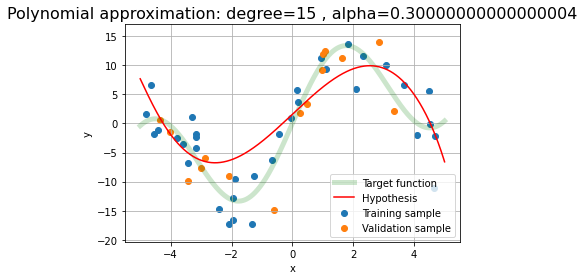

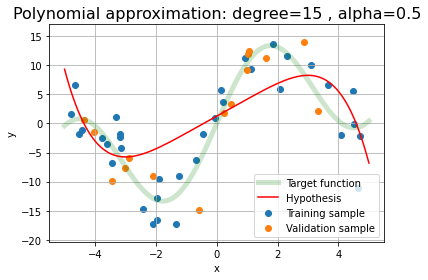

In [21]:
w=[]

for alpha in ALPHAS:
    lasso=make_model(degree=15, penalty='L1', alpha=alpha)
    l_coeffs=lasso.fit(X_train, y_train)['reg'].coef_
    w.append(l_coeffs)
    if alpha in [0, ALPHAS[3], ALPHAS[24], 0.5]:
        plot_fit(lasso, add_title=', alpha='+str(alpha))

w_i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Alpha,,,,,,,,,,,,,,,,
0.0000,0.0,33.544287,-7.399158,-37.434008,-127.812952,-473.619689,994.290665,2910.252779,-2261.136284,-7770.357341,1930.663785,10759.220096,-350.338737,-7447.970641,-179.921029,2028.803972
0.0125,0.0,29.884555,-2.917159,-47.583442,8.176581,0.000000,-0.000000,29.593734,-5.982205,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-9.507557
0.0250,0.0,27.920251,-0.000000,-41.335204,2.033817,0.000000,-0.000000,21.833312,-0.000000,0.000000,-2.518786,0.000000,-0.000000,-0.000000,-0.000000,-6.004842
0.0375,0.0,25.915077,0.000000,-35.348023,1.966984,0.000000,-0.000000,14.622563,-0.000000,0.000000,-2.362843,0.000000,-0.000000,-0.000000,-0.000000,-2.801862
0.0500,0.0,24.106128,1.040421,-29.882758,0.228452,0.000000,-0.000000,8.161169,-0.000000,0.000000,-1.521764,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
0.0625,0.0,22.738773,1.197550,-25.758135,0.000000,0.000000,-0.000000,0.000000,-0.000000,5.337930,-1.414749,0.000000,-0.000000,0.000000,-0.000000,-0.000000
0.0750,0.0,22.042686,1.126201,-24.477391,0.000000,0.000000,-0.000000,0.000000,-0.000000,4.666831,-0.882087,0.000000,-0.470711,0.000000,-0.000000,0.000000
0.0875,0.0,21.318568,1.054269,-23.144374,0.000000,0.000000,-0.000000,0.000000,-0.000000,3.967103,-0.250272,0.000000,-1.042418,0.000000,-0.000000,0.000000
0.1000,0.0,20.577653,1.015904,-21.627403,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.993215,-0.000000,1.123038,-1.253842,0.000000,-0.000000,0.000000


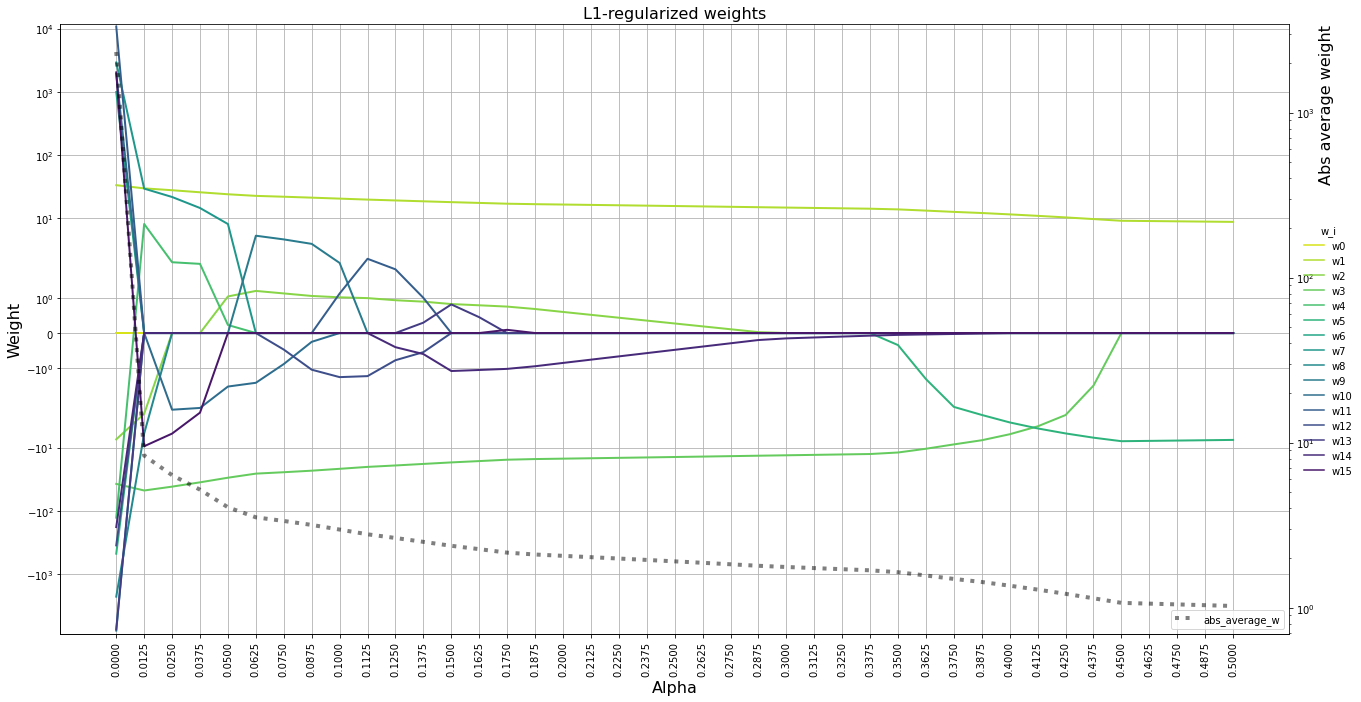

In [22]:
palette=sns.color_palette('viridis_r',16)

df=task1(ALPHAS, w, palette=palette, title='L1-regularized weights')
palette
df

#### L2

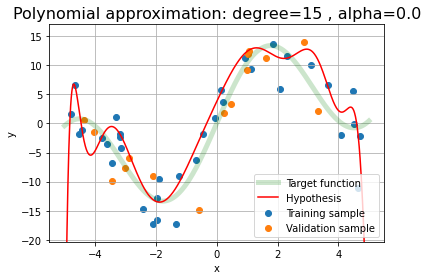

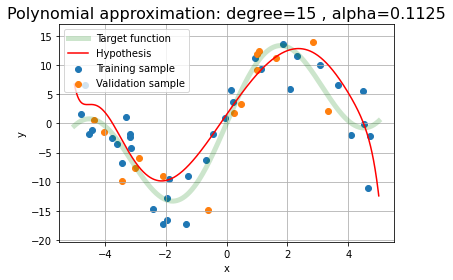

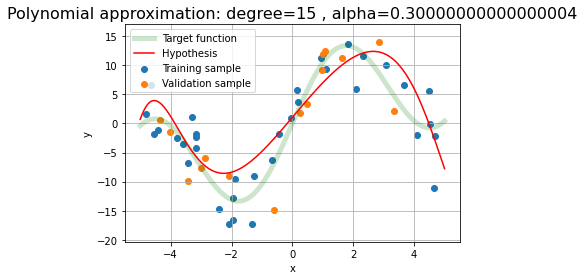

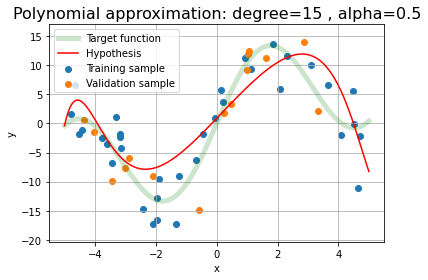

In [35]:
w=[]

for alpha in ALPHAS:
    lasso=make_model(degree=15, penalty='L2', alpha=alpha)
    l_coeffs=lasso.fit(X_train, y_train)['reg'].coef_
    w.append(l_coeffs)
    if alpha in [0, ALPHAS[9], ALPHAS[24], 0.5]:
        plot_fit(lasso, add_title=', alpha='+str(alpha))

w_i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Alpha,,,,,,,,,,,,,,,,
0.0000,0.0,33.544287,-7.399158,-37.434008,-127.812952,-473.619689,994.290665,2910.252779,-2261.136284,-7770.357341,1930.663785,10759.220096,-350.338737,-7447.970641,-179.921029,2028.803972
0.0125,0.0,29.420854,-7.450420,-45.753656,22.653026,1.486257,-8.820215,16.702241,-11.062981,12.458043,-1.431452,2.896187,4.538058,-5.273732,0.741246,-9.524097
0.0250,0.0,27.854604,-5.632728,-39.597585,16.856605,-2.948204,-4.335745,13.100540,-8.387751,12.711778,-3.468944,5.497024,1.529675,-3.222926,2.694749,-11.022734
0.0375,0.0,26.741795,-4.542378,-35.870171,14.016723,-4.632528,-2.874597,10.964403,-7.094752,11.977063,-3.780723,6.036111,0.599857,-2.253747,3.005546,-10.616109
0.0500,0.0,25.840792,-3.756891,-33.085153,12.171065,-5.504426,-2.184979,9.390039,-6.266714,11.097785,-3.750880,6.053807,0.184261,-1.632420,2.995283,-9.834870
0.0625,0.0,25.077235,-3.149344,-30.839859,10.826428,-6.026232,-1.797335,8.136971,-5.668800,10.243878,-3.626713,5.895054,-0.035552,-1.181551,2.894009,-8.999366
0.0750,0.0,24.414260,-2.660882,-28.959690,9.784653,-6.364669,-1.554491,7.101223,-5.206857,9.457104,-3.477437,5.672995,-0.164041,-0.833052,2.765337,-8.200557
0.0875,0.0,23.829213,-2.258227,-27.348286,8.945792,-6.594775,-1.390039,6.225335,-4.834051,8.744422,-3.326489,5.432012,-0.244524,-0.553494,2.630979,-7.464810
0.1000,0.0,23.306593,-1.920326,-25.944677,8.252105,-6.755441,-1.271654,5.472877,-4.523847,8.102090,-3.182329,5.191113,-0.297704,-0.323768,2.499115,-6.796818


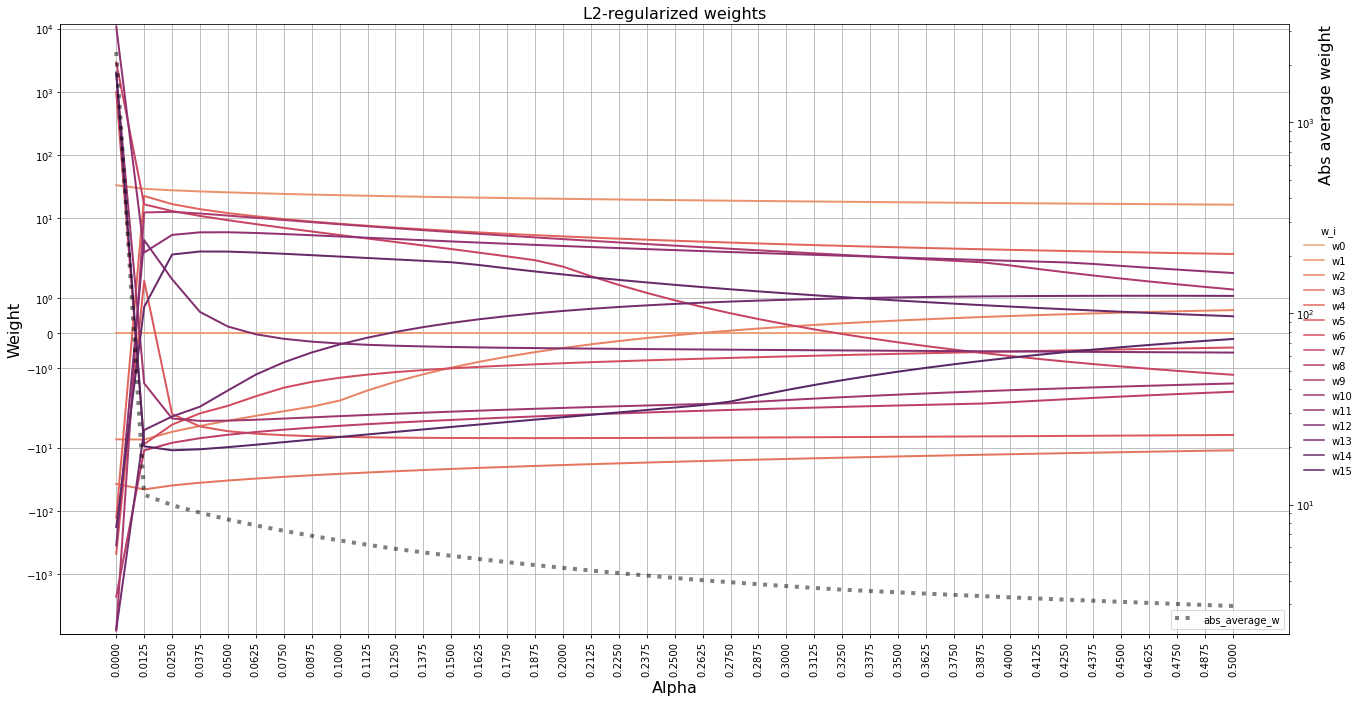

In [34]:
palette=sns.color_palette('flare',16)

df=task1(ALPHAS, w, "L2-regularized weights", palette=palette)

palette
df

#### Summary

Как и следовало ожидать, L1 зануляет некоторые веса, L2 укрощает их, но не делает нулевыми. Видно (особенно если выйти за предел alpha=0.5), что средний вес приближается к 0 по мере возрастания параметра регуляризации, что объясняется тем, что l1 or l2-норма вектора w, умноженная на alpha, становится доминирующей в формуле наименьших квадратов: RSS + alpha ||w||. (Прим.: RSS = N * MSE).
Видно, что слева, при alpha~0, коэффициенты при весах довольно большие, что является признаком переобучения, модель старается аппроксимировать стохастические шумы, тоесть пытается интерполировать исходныеданные.

В разложении ряда Маклорена функция f(x)=2x+10 sin(x)  ~  12x - 10x^3/6 + 10x^5/120 - 10x^7/7! + ... - 10x^15/15! + ...
В случае L1 видно, что относительно малые веса, а при возрастании alpha - и вовсе зануленные веса - у нечетных степеней, что можно объяснить тем, что в разложении нечетной функции участвуют только нечетные степени переменной, которые получены в результате Lasso feature selection. Аналогичное наблюдение можно сделать и для L2: наибольшие веса В БОЛЬШИНСТВЕ СЛУЧАЕВ принадлежат нечетным степеням, но они не обязательно намного больше. 

Можно заметить, что наибольшие коэффициенты принадлежат первой и третьей степеням переменной. Это можно объяснить целевой функцией: 
в ее разложении 2 "ярких" коэффициента: при первой (12) и при третьей (-1.666) степенях. Соответственно, гораздо большие значения при оных будут "гасить" аппроксимированные шумы. Можно также заметить наличие большого и отрицательного, в отличие от оного в разложении Маклорена, коэффициента при пятой степени. Видим, что пятая степень привносит отрицательную тенденцию в разброс и гасит аппроксимацию шумов. 
Наличие относительно больших коэффициентов при этих степенях можно также объяснить тем, что в разбросе наблюдается 4 экстремума (здесь мы говорим как про известную нам целевую функцию, так и про то, что точки наблюдений будут в их, экстремумов, окрестностях разбросаны ПЛОТНЕЕ (как если бы мы накладывали две полосы "нисходящей" и "восходящей" тенденций концами друг на друга)) - а наиболее простой полином с 4 экстремумами - это полином 5 степени. Однако реально - по точкам наблюдений - видно только 2 экстремума ((-4,0), (4, 10)), поэтому корректно говорить, что "излишки в коэффииентах" (например, x^5: 10/120-(-6)=6) гасят шумы или сами их включают.
Кросс-валидация не использовалась, это допустимо, однако при ее использовании заключения будут те же.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [22]:
## your code

#### L2

In [23]:
## your code

#### Summary

In [24]:
По сути задача рассмотрена в предыдущем таске. Тк. степени переменной х в рассмотренной ранее линейной регрессии - это по сути разные признаки, то зануление коэффициентов при них можно рассматривать как выбор остальных степеней, то есть прищнаков

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

In [100]:
data = pd.read_csv("data.csv", index_col='ID')
data['Height']=data['Height'].str.extract(r'([1-9])\'([0-9]+)').astype(float)\
                                                              .apply(\
                                                                        lambda row: (12*row.iloc[0]+row.iloc[1])*0.0254,\
                                                               axis=1)
data['Weight'] = data['Weight'].str.extract(r'([0-9]+)lbs').astype(float)
POUND_TO_KILO = 0.454
data['Weight'] = data.apply(lambda row: row['Weight'] * POUND_TO_KILO, axis=1)

data.dropna(subset=['Height', 'Weight'], axis=0, inplace=True)

data=data[['Height', 'Weight']]
#data.hist(column='Weight', bins=20)
#plt.show()
X=data['Height'].to_numpy().reshape(-1,1)
y=data['Weight'].to_numpy()
data=data.iloc[1:20]

<AxesSubplot:xlabel='Height', ylabel='Weight'>

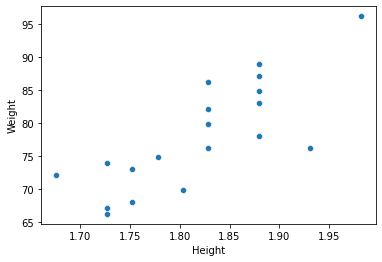

In [101]:
sns.scatterplot(data=data, x='Height', y='Weight')

In [107]:
model=make_model(degree=15, penalty='L1', alpha=0.1)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=SEED)
model=model.fit(X_train, y_train)

y_pred_train=model.predict(X_train)
y_pred=model.predict(X_test)
rmse_train=rmse(y_train, y_pred_train)
rmse_valid=rmse(y_test, y_pred)
print(f'rmse_train={rmse_train}, rmse_valid={rmse_valid}')

rmse_train=75.48000899540078, rmse_valid=75.53618142881253


In [103]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

model=model.fit(X_train_scaled, y_train)
y_pred_train=model.predict(X_train_scaled)
y_pred=model.predict(X_test_scaled)

#np.shape(y_pred_train)
rmse_train=rmse(y_train, y_pred_train)
rmse_valid=rmse(y_test, y_pred)

print(f'rmse_train={rmse_train}, rmse_valid={rmse_valid}')

rmse_train=75.48006901350614, rmse_valid=75.5364985097103


у меня не получилось это показать, но масштабирование может быть важно для определенного распределения данных. Так, в случае определения зарплаты спортсменов очень многие признаки имеют разные по разбросу или абсолютным значениям распределения, поэтому важно привести их "к общему знаменателю"